<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 4.4: Regularisation

In this lab, we explore regularisation techniques, specifically Lasso and Ridge regression. Regularisation helps prevent overfitting by penalising large coefficients, thereby promoting simpler models. We provide an introduction to Lasso and Ridge regression, highlighting their differences and advantages in handling multicollinearity and feature selection. Through practical implementation, we demonstrate how regularisation enhances model stability and generalisation performance.

In [22]:
## Import Libraries

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

## Avoid some version change warnings
import warnings
warnings.filterwarnings('ignore', message='numpy.dtype size changed')

### 1. Regularisation

The goal of "regularising" regression models is to structurally prevent overfitting by imposing a penalty on the coefficients of the model.

Regularisation methods like the Ridge and Lasso add this additional "penalty" on the size of coefficients to the loss function. When the loss function is minimized, this additional component is added to the residual sum of squares.

In other words, the minimisation becomes a balance between the error between predictions and true values and the size of the coefficients.

The two most common types of regularisation are the **Lasso**, **Ridge**.

#### 1.1 Load Diabetics Data Using datasets of sklearn

Hint: Check Lab 4.3

In [23]:
## Load the Diabetes dataset

# Load the diabetes dataset from sklearn

diabetes = datasets.load_diabetes()

In [24]:
# Description
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [25]:
# Predictors
X = pd.DataFrame(diabetes.data, columns = diabetes.feature_names)

In [26]:
X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


In [27]:
# Target
y = diabetes.target

#### 1.2 Create a Base Model Using Linear Regression

In [28]:
# Create Model
model = LinearRegression()


In [29]:
# Fit
model.fit(X,y)

LinearRegression()

In [30]:
# Score
model.score(X,y)

0.5177484222203499

In [31]:
# Check Coeffiricent
model.coef_

array([ -10.0098663 , -239.81564367,  519.84592005,  324.3846455 ,
       -792.17563855,  476.73902101,  101.04326794,  177.06323767,
        751.27369956,   67.62669218])

In [32]:
X.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

In [33]:
# y = -10*age - 239*sex + 519*BMI + ...

In [34]:
def view_coeff(X, model):
    model_coefs = pd.DataFrame({'variable': X.columns,
                                'coef': model.coef_,
                                'abs_coef': np.abs(model.coef_)})
    model_coefs.sort_values('abs_coef', inplace=True, ascending=False)
    sns.barplot(x="variable", y="coef", data=model_coefs)

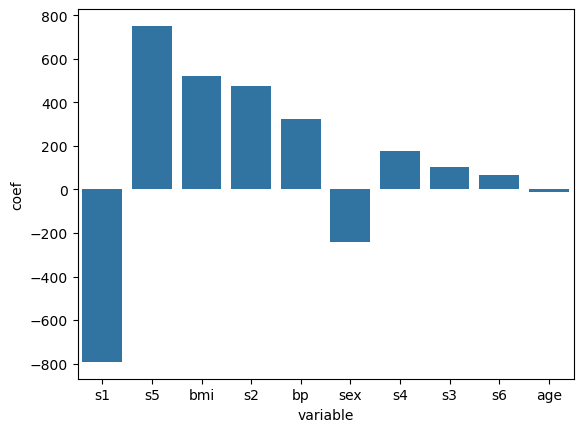

In [35]:
# Plot Coefficients
view_coeff(X, model)

#### 1.3 Ridge

##### 1.3.1 Calculate Ridge Regression model

In [36]:
## Calculate Ridge Regression model

# create a model object to hold the modelling parameters
ridgemodel = Ridge()

# keep track of the intermediate results for coefficients and errors
coefs = []
errors = []

# create a range of alphas to calculate
ridge_alphas = np.logspace(-6, 6, 200) #lambda in the slides

# Train the model with different regularisation strengths
for a in ridge_alphas:
    ridgemodel.set_params(alpha = a)
    ridgemodel.fit(X, y)
    coefs.append(ridgemodel.coef_)
    errors.append(mean_squared_error(ridgemodel.coef_, model.coef_))

In [37]:
len(coefs)

200

##### 1.3.2 Visual Representation of Coefficient of Ridge Model

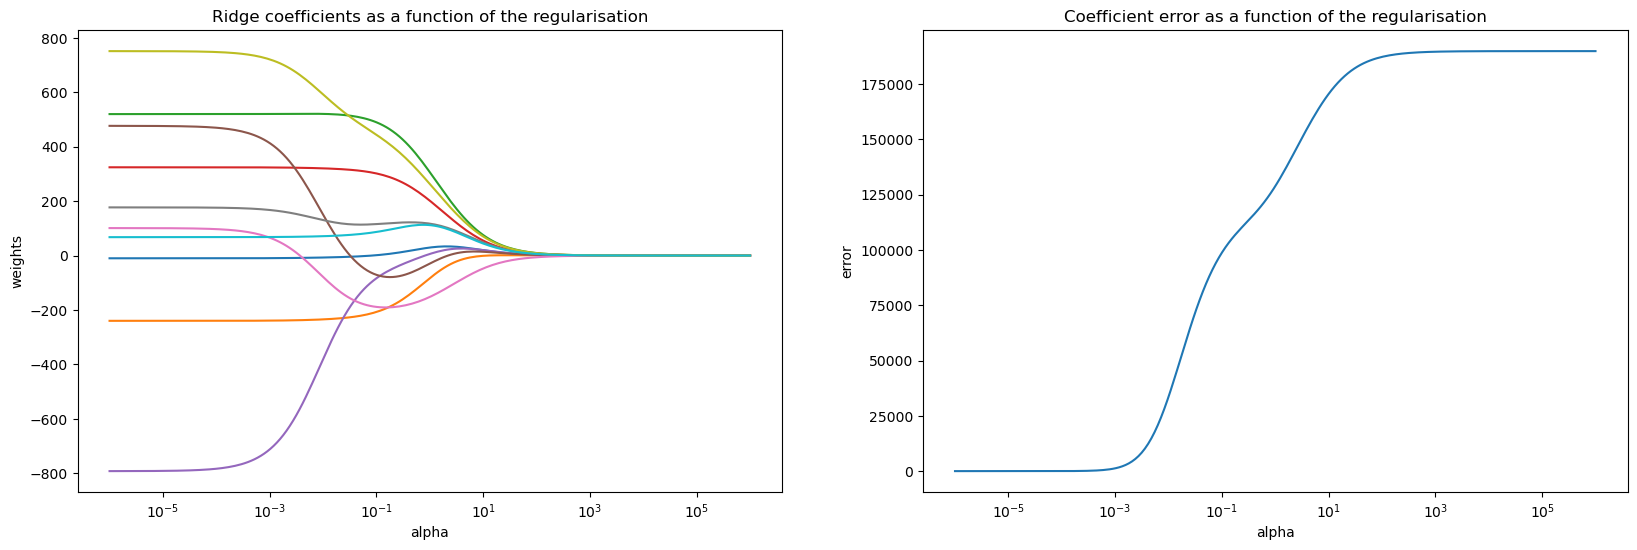

In [38]:
# Display results
plt.figure(figsize = (20, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(ridge_alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularisation')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(ridge_alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Coefficient error as a function of the regularisation')
plt.axis('tight')

plt.show()

##### 1.3.3. [BONUS]  Find an optimal value for Ridge regression alpha using `RidgeCV`.

[Go to the documentation and read how RidgeCV works.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV).

Note here that you will be optimizing both the alpha parameter and the l1_ratio:
- `alpha`: strength of regularisation

In [39]:
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X, y)
print('Alpha:', optimal_ridge.alpha_)
print('Score:', optimal_ridge.score(X, y))

Alpha: 0.06669919663030115
Score: 0.5138352359035856


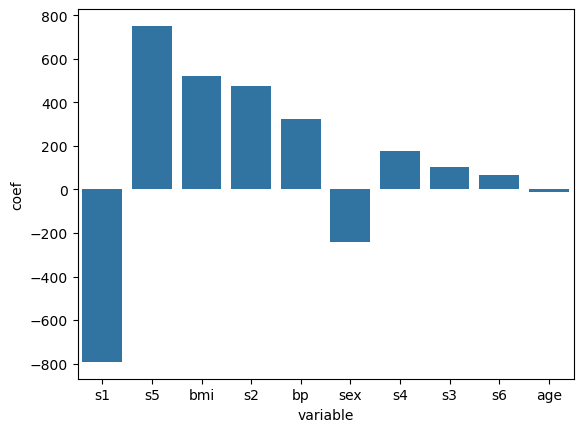

In [40]:
view_coeff(X, model)

In [41]:
optimal_ridge.coef_

array([  -1.26474186, -216.39460047,  501.54971795,  308.13254162,
       -112.18452928,  -54.47177855, -182.30247501,  114.03129811,
        466.75421801,   81.94402103])

#### 1.4 Lasso

##### 1.4.1 Calculate Lasso Regression model

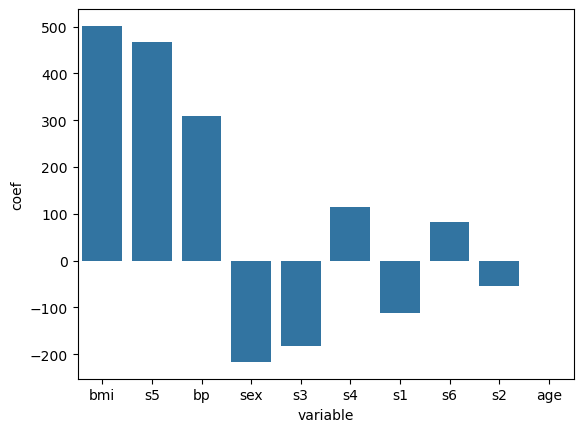

In [42]:
view_coeff(X, optimal_ridge)

In [43]:
## Calculate Lasso Regression model

# create a model object to hold the modelling parameters
lassomodel = Lasso()

# keep track of the intermediate results for coefficients and errors
coefs = []
errors = []

# create a range of alphas to calculate
lasso_alphas = np.logspace(-6, 6, 200)

# Train the model with different regularisation strengths
for a in lasso_alphas:
    lassomodel.set_params(alpha = a)
    lassomodel.fit(X, y)
    coefs.append(lassomodel.coef_)
    errors.append(mean_squared_error(lassomodel.coef_, model.coef_))


##### 1.4.2 Visual Representation of Coefficient of Lasso Model

Hint: Same as Ridge

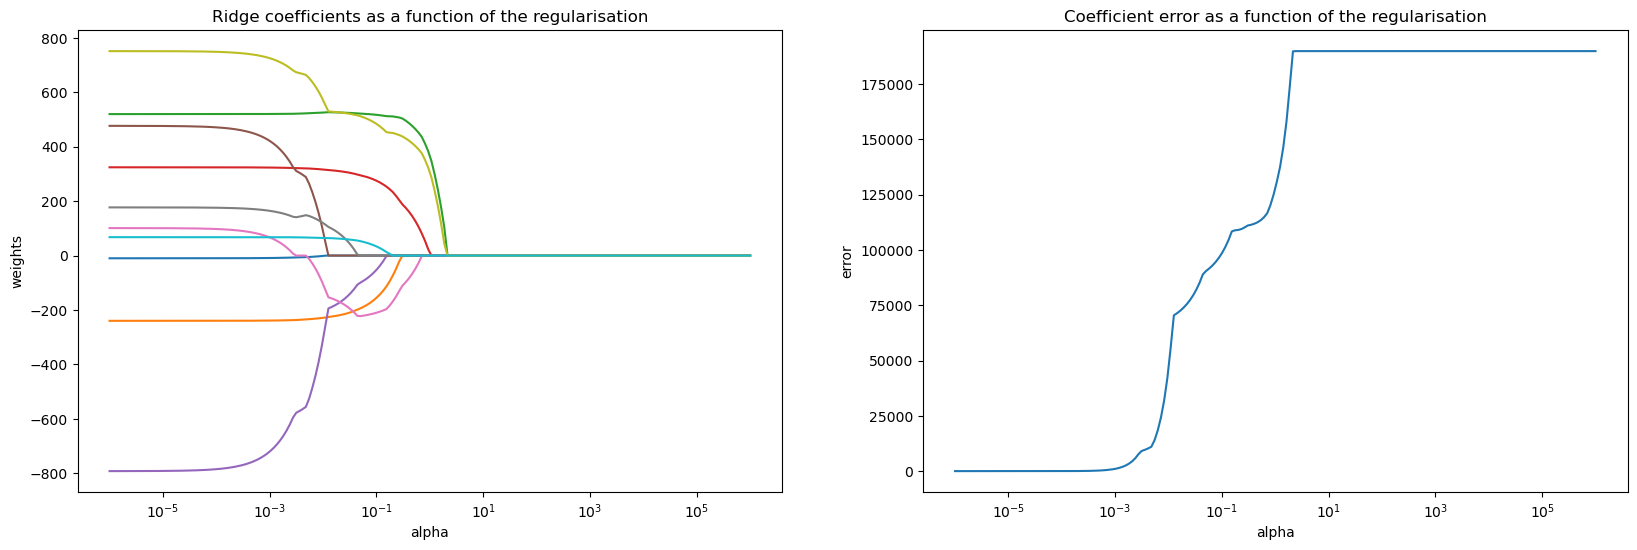

In [44]:
# Display results
plt.figure(figsize = (20, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(lasso_alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularisation')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(lasso_alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Coefficient error as a function of the regularisation')
plt.axis('tight')

plt.show()

##### 1.4.3. [BONUS]  Find an optimal value for Lasso regression alpha using `LassoCV`.

[Go to the documentation and read how LassoCV works.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV).

Note here that you will be optimizing both the alpha parameter and the l1_ratio:
- `alpha`: strength of regularisation

In [50]:
optimal_lasso = LassoCV(alphas=lasso_alphas, cv=10)
optimal_lasso.fit(X, y)
print('Alpha:', optimal_lasso.alpha_)
print('Score:', optimal_lasso.score(X, y))

Alpha: 0.05805225516094896
Score: 0.5126478025867265


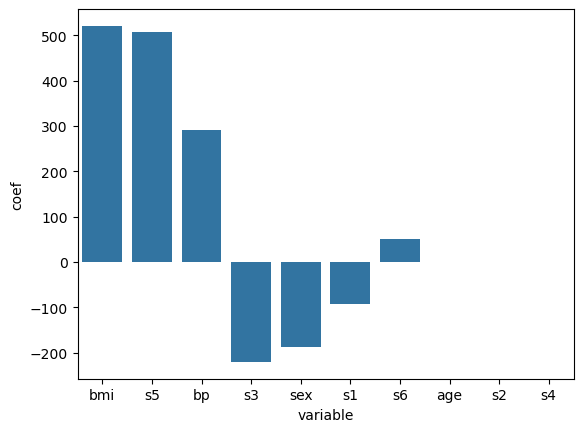

In [51]:
view_coeff(X, optimal_lasso)

### 2. [Bonus] Compare the residuals for the Ridge and Lasso visually.

Find and create sctterplot for both Ridge and Lasso residuals.

In [52]:
# Build the ridge and lasso using optimal alpha
ridge = Ridge(alpha=optimal_ridge.alpha_)
lasso = Lasso(alpha=optimal_lasso.alpha_)

# Need to fit the Lasso and Ridge outside of cross_val_score like we did with the ridge
ridge.fit(X, y)
lasso.fit(X, y)

Lasso(alpha=0.05805225516094896)

In [53]:
# model residuals:

ridge_resid = y - ridge.predict(X)
lasso_resid = y - lasso.predict(X)

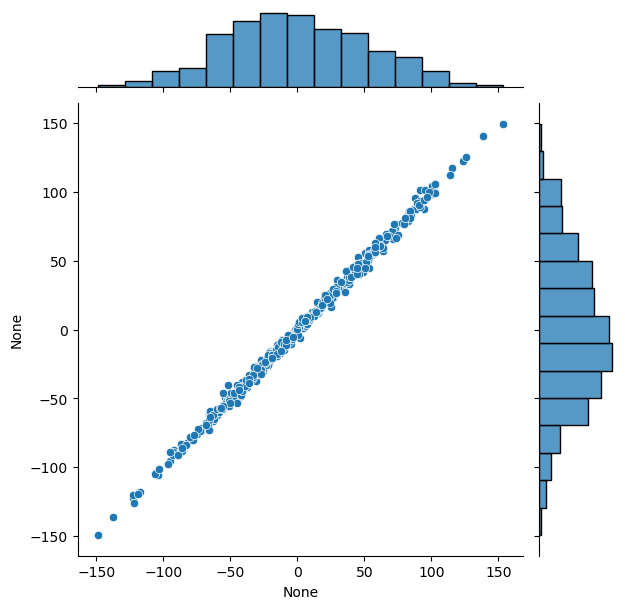

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ridge_resid and lasso_resid are your data arrays
sns.jointplot(x=ridge_resid, y=lasso_resid)

plt.show()




---



---



> > > > > > > > > © 2024 Institute of Data


---



---



